# ADS proj -- School & Crime

## _Census tract level_

by: Emily Padvorac, Matt Dwyer, Rebecca Scheidegger, Dana Chermesh

_**NYU CUSP**, Fall 2017_

In [2]:
from __future__ import print_function, division
import sys
import os
import numpy as np
import pylab as pl
#importing pandas for reading and parsing of tabulated data
import pandas as pd
#importing geopandas read to plot geographical information
import geopandas as gpd
#importing fiona to handle geographical coordinates
import fiona
#import shapely to handle geographical shapes
import shapely
import json
import requests 
import urllib

import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style('whitegrid')
%pylab inline

import statsmodels.formula.api as smf
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/dcr346/PUIdata


## Read in School shapefile (points)

In [4]:
schoolshp = gpd.GeoDataFrame.from_file(PUIDATA +"/Public_Schools_Points_2011-2012A.shp")
#schoolshp.crs = from_epsg(2263) 
schoolshp.head()

,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,NY,11220,Jennifer Eusanio,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163)
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,NY,11226,ADRIENNE SPENCER,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498)
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,NY,11223,Janet Ndzibah,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244)
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,NY,11204,Denise Sandra Levinsky,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183)
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,NY,11223,KRISTINE MUSTILLO,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843)


In [5]:
schoolshp.dtypes

ATS_CODE       object
BORO           object
BORONUM       float64
LOC_CODE       object
SCHOOLNAME     object
SCH_TYPE       object
MANAGED_BY      int64
GEO_DISTRI      int64
ADMIN_DIST      int64
ADDRESS        object
STATE_CODE     object
ZIP             int64
PRINCIPAL      object
PRIN_PH        object
FAX            object
GRADES         object
City           object
geometry       object
dtype: object

In [6]:
schoolshp.shape

(1709, 18)

## Read in Census Tracts shapefile

In [7]:
ctshp = gpd.GeoDataFrame.from_file(PUIDATA + '/ct_shape.shp')
ctshp.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
2,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
3,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
4,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


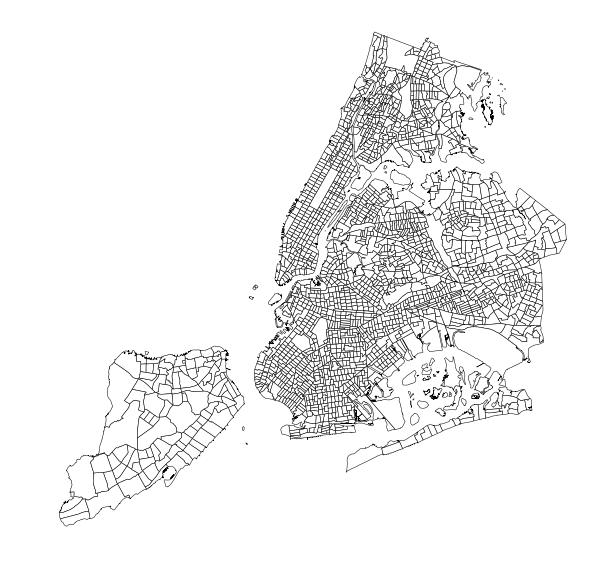

In [8]:
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(ctshp, column=None, color="white", edgecolor="black", lw=.5);

In [9]:
ctshp.shape

(2166, 12)

## Read in School Progress Data

In [10]:
schools2007 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/CA6CD49D-E595-4272-B594-385A6A3229A3/0/2007ProgressReportResults_011409.xls", skiprows=0)
schools2013 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/1550033E-3F15-4746-BD1A-DF3364721785/0/2012_2013_EMS_PR_Results_2014_04_24.xlsx", skiprows=1)

## Cleaning 2007 data

In [11]:
schools2007 = schools2007.dropna(0)
#schools2007 = schools2007.reset_index()

In [12]:
columns = (np.asarray(schools2007.iloc[:1,:]))
schools2007.columns = columns[0]
schools2007 =  schools2007.iloc[1:,:]

schools2007.head()

,DBN,DISTRICT,SCHOOL,SCHOOL SUPPORT ORGANIZATION/NETWORK,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,GRADE,OVERALL SCORE,ENVIRONMENT CATEGORY SCORE,PERFORMANCE CATEGORY SCORE,PROGRESS CATEGORY SCORE,ADDITIONAL CREDIT,QUALITY REVIEW SCORE
NaN,01M015,01,PS 015 ROBERTO CLEMENTE,ICI15,ESMS,Elementary School,75.6,B,52.31,0.278,0.231,0.694,3,Undeveloped
NaN,01M019,01,PS 019 ASHER LEVY,ESO1,ESMS,Elementary School,59.25,B,51.24,0.51,0.466,0.511,1.5,Proficient
NaN,01M020,01,PS 020 ANNA SILVER,ICI15,ESMS,Elementary School,69.78,B,52.59,0.568,0.682,0.402,1.5,Well-Developed
NaN,01M034,01,PS 034 FRANKLIN D ROOSEVELT,ICI15,ESMS,K-8 School,71.9,C,47.02,0.409,0.366,0.53,0.75,Proficient
NaN,01M063,01,PS 063 WILLIAM MCKINLEY,ICI15,ESMS,Elementary School,62.17,C,44.66,0.199,0.511,0.479,0,Proficient


In [13]:
# create numerical rating

schools2007['Rating'] = schools2007['GRADE'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})

In [14]:
schools2007 = schools2007[['DBN','SCHOOL','SCHOOL LEVEL*','Rating']]
schools2007.head()

,DBN,SCHOOL,SCHOOL LEVEL*,Rating
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [15]:
schools2007.columns = ['DBN','SchoolName','SchoolType','Rating07']
schools2007.head()

,DBN,SchoolName,SchoolType,Rating07
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [16]:
schools2007['DBN'] = schools2007['DBN'].str[2:]
schools2007.head()

,DBN,SchoolName,SchoolType,Rating07
NaN,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [17]:
schools2007.shape

(1224, 4)

## Cleaning 2013 data

In [18]:
schools2013['Rating'] = schools2013['Overall Grade'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})

In [19]:
schools2013 = schools2013[['DBN','School Name','School Type','Rating']]
schools2013.columns = ['DBN','SchoolName','SchoolType','Rating13']
schools2013['DBN'] = schools2013['DBN'].str[2:]
schools2013.head()

,DBN,SchoolName,SchoolType,Rating13
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0
1,M019,P.S. 019 Asher Levy,Elementary,5.0
2,M020,P.S. 020 Anna Silver,Elementary,4.0
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0
4,M063,The STAR Academy - P.S.63,Elementary,3.0


In [20]:
schools2013.shape

(1198, 4)

## Merge 2007 + 2013

In [21]:
schools = schools2007.merge(schools2013, on='DBN')
schools = schools[['DBN','Rating07','Rating13']]
schools['RatingChange'] = schools['Rating13'] / schools['Rating07'] * 100

schools.head()

,DBN,Rating07,Rating13,RatingChange
0,M015,4.0,3.0,75.000000
1,M019,4.0,5.0,125.000000
2,M020,4.0,4.0,100.000000
3,M034,3.0,5.0,166.666667
4,M063,3.0,3.0,100.000000


In [22]:
schools.shape

(994, 4)

## Merge School scores w School shp

In [23]:
gschools = schools.merge(schoolshp, left_on='DBN', right_on='LOC_CODE')
gschools.head()

,DBN,Rating07,Rating13,RatingChange,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,...,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,M015,4.0,3.0,75.000000,01M015,M,1.0,M015,P.S. 015 ROBERTO CLEMENTE,Elementary,...,1,333 EAST 4 STREET,NY,10009,IRENE SANCHEZ,212-228-8730,212-477-0931,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (990123.2547304605 202281.6311154864)
1,M019,4.0,5.0,125.000000,01M019,M,1.0,M019,P.S. 019 ASHER LEVY,Elementary,...,1,185 1 AVENUE,NY,10003,JACQUELINE FLANAGAN,212-533-5340,212-673-1477,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988634.7054615917 205140.7731699182)
2,M020,4.0,4.0,100.000000,01M020,M,1.0,M020,P.S. 020 ANNA SILVER,Elementary,...,1,166 ESSEX STREET,NY,10002,JAMES LEE,212-254-9577,212-254-3526,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988025.1479657721 202056.5849334946)
3,M034,3.0,5.0,166.666667,01M034,M,1.0,M034,P.S. 034 FRANKLIN D. ROOSEVELT,K-8,...,1,730 EAST 12 STREET,NY,10009,JOYCE STALLINGS HARTE,212-228-4433,212-353-1973,"PK,0K,01,02,03,04,05,06,07,08,SE",MANHATTAN,POINT (991118.12310576 203875.9493196165)
4,M063,3.0,3.0,100.000000,01M063,M,1.0,M063,P.S. 063 WILLIAM MCKINLEY,Elementary,...,1,121 EAST 3 STREET,NY,10009,DARLENE DESPEIGNES,212-674-3180,212-420-9018,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988036.345197865 203208.4555002286)


In [24]:
gschools.shape

(994, 22)

In [25]:
gschools.columns

Index(['DBN', 'Rating07', 'Rating13', 'RatingChange', 'ATS_CODE', 'BORO',
       'BORONUM', 'LOC_CODE', 'SCHOOLNAME', 'SCH_TYPE', 'MANAGED_BY',
       'GEO_DISTRI', 'ADMIN_DIST', 'ADDRESS', 'STATE_CODE', 'ZIP', 'PRINCIPAL',
       'PRIN_PH', 'FAX', 'GRADES', 'City', 'geometry'],
      dtype='object')

In [26]:
gschools =  gschools[['DBN','Rating07', 'Rating13', 'RatingChange','BORO', 'ZIP','geometry']]
gschools.head()

,DBN,Rating07,Rating13,RatingChange,BORO,ZIP,geometry
0,M015,4.0,3.0,75.000000,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,4.0,5.0,125.000000,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,4.0,4.0,100.000000,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,3.0,5.0,166.666667,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,3.0,3.0,100.000000,M,10009,POINT (988036.345197865 203208.4555002286)


In [27]:
gschools.to_csv('gschools.csv')

# Spatial Join (.sjoin) with CT shp (point+polygons)

In [28]:
type(gschools)

pandas.core.frame.DataFrame

In [29]:
crs = {'init': 'epsg:2263'}
gschools = gpd.GeoDataFrame(gschools, crs=crs, geometry=gschools.geometry)
type(gschools)

geopandas.geodataframe.GeoDataFrame

In [30]:
gschools.head()

,DBN,Rating07,Rating13,RatingChange,BORO,ZIP,geometry
0,M015,4.0,3.0,75.000000,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,4.0,5.0,125.000000,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,4.0,4.0,100.000000,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,3.0,5.0,166.666667,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,3.0,3.0,100.000000,M,10009,POINT (988036.345197865 203208.4555002286)


In [31]:
gschools.crs

{'init': 'epsg:2263'}

In [32]:
ctshp.crs

{'init': 'epsg:4326'}

In [33]:
ctshp = ctshp.to_crs({'init': 'epsg:2263'})
ctshp.crs

{'init': 'epsg:2263'}

In [34]:
# .sjoin

gschools = gpd.sjoin(gschools, ctshp, how='right', op='within')
gschools.head()

,index_left,DBN,Rating07,Rating13,RatingChange,BORO,ZIP,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
index_right,,,,,,,,,,,,,,,,,,,
0,943.0,R031,2.0,4.0,200.0,R,10301.0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,"POLYGON ((962269.1260375973 173705.5001830472,..."
1,940.0,R027,3.0,3.0,100.0,R,10310.0,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,"POLYGON ((951998.5532226549 168438.0043944769,..."
4,949.0,R039,4.0,4.0,100.0,R,10305.0,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((966615.2556152344 158662.2927855851,..."
5,954.0,R046,1.0,3.0,300.0,R,10305.0,5006400,5,Staten Island,I,006400,64,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,7.643184e+06,12726.360406,"POLYGON ((963023.8917846683 158246.7521972115,..."
9,18.0,M363,4.0,3.0,75.0,M,10009.0,1003200,1,Manhattan,I,003200,32,MN22,East Village,3809,2.334190e+06,6358.386684,"POLYGON ((989819.2963867191 204093.9949950601,..."


In [35]:
type(gschools)

geopandas.geodataframe.GeoDataFrame

In [36]:
#counts = gschools.groupby([gschools['CT2010']]).count()
#counts['index_left'].max()

In [37]:
gschools = gschools.groupby([gschools['CT2010']]).mean()
gschools.head()

,index_left,Rating07,Rating13,RatingChange,ZIP,Shape_Area,Shape_Leng
CT2010,,,,,,,
000100,646.000000,4.000000,4.000000,100.000000,11155.0,8.630657e+06,19199.803153
000200,NaN,NaN,NaN,NaN,NaN,3.223113e+06,10028.355630
000201,13.333333,3.666667,4.666667,130.555556,10002.0,9.716282e+05,4748.703650
000202,7.500000,4.000000,3.000000,75.000000,10002.0,3.315121e+06,8568.208367
000300,NaN,NaN,NaN,NaN,NaN,4.119510e+06,16907.246311


In [38]:
gschools = gschools[['Rating07','Rating13','RatingChange']]
gschools.head()

,Rating07,Rating13,RatingChange
CT2010,,,
000100,4.000000,4.000000,100.000000
000200,NaN,NaN,NaN
000201,3.666667,4.666667,130.555556
000202,4.000000,3.000000,75.000000
000300,NaN,NaN,NaN


In [39]:
gschools.shape

(1335, 3)

In [40]:
gschools = gschools.dropna(0)
gschools.head()

,Rating07,Rating13,RatingChange
CT2010,,,
000100,4.000000,4.000000,100.000000
000201,3.666667,4.666667,130.555556
000202,4.000000,3.000000,75.000000
000600,4.000000,5.000000,125.000000
000800,4.000000,4.000000,100.000000


In [41]:
#gschools.shape

In [42]:
gschools = gschools.reset_index()
gschools.head()

,CT2010,Rating07,Rating13,RatingChange
0,000100,4.000000,4.000000,100.000000
1,000201,3.666667,4.666667,130.555556
2,000202,4.000000,3.000000,75.000000
3,000600,4.000000,5.000000,125.000000
4,000800,4.000000,4.000000,100.000000


In [43]:
# merge with CT shp

schoolsCT = gschools.merge(ctshp, on='CT2010')
schoolsCT.head()

,CT2010,Rating07,Rating13,RatingChange,BoroCT2010,BoroCode,BoroName,CDEligibil,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,000100,4.000000,4.000000,100.000000,2000100,2,Bronx,I,1,BX98,Rikers Island,3710,1.815460e+07,18903.346859,"POLYGON ((1019454.697021484 225654.3287963268,..."
1,000100,4.000000,4.000000,100.000000,1000100,1,Manhattan,I,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((972081.7880249015 190733.4670409563...
2,000100,4.000000,4.000000,100.000000,4000100,4,Queens,I,1,QN31,Hunters Point-Sunnyside-West Maspeth,4109,1.228633e+07,40345.536003,"POLYGON ((998348.4624023447 214174.0826415403,..."
3,000100,4.000000,4.000000,100.000000,3000100,3,Brooklyn,I,1,BK09,Brooklyn Heights-Cobble Hill,4004,2.237282e+06,6527.281839,"POLYGON ((986764.3486328113 194584.624389593, ..."
4,000201,3.666667,4.666667,130.555556,1000201,1,Manhattan,E,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,"POLYGON ((988548.2182006848 197770.3748168389,..."


In [44]:
schoolsCT.shape

(1173, 15)

In [45]:
schoolsCT.dtypes

CT2010           object
Rating07        float64
Rating13        float64
RatingChange    float64
BoroCT2010       object
BoroCode         object
BoroName         object
CDEligibil       object
CTLabel          object
NTACode          object
NTAName          object
PUMA             object
Shape_Area      float64
Shape_Leng      float64
geometry         object
dtype: object

In [46]:
schoolsCT['CT2010'] = schoolsCT['CT2010'].astype(int)

In [47]:
crs = {'init': 'epsg:2263'}
geoschoolsCT = gpd.GeoDataFrame(schoolsCT, crs=crs, geometry=schoolsCT.geometry)

In [48]:
geoschoolsCT.to_csv('geoschoolsCT.csv')

# Plot School Ratings by CT

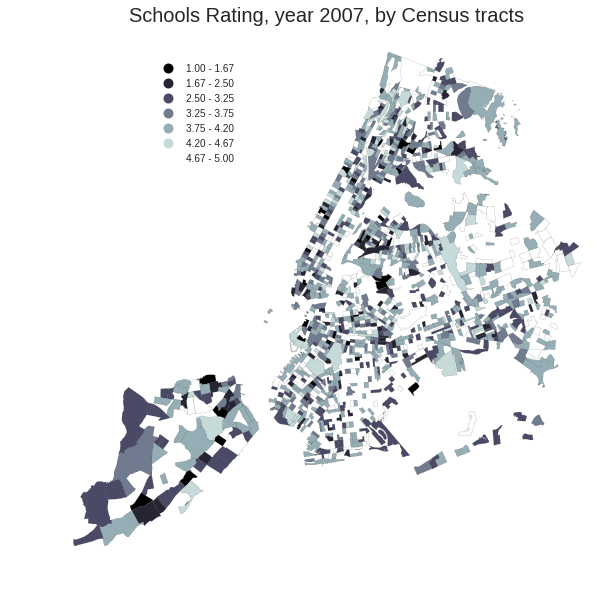

In [49]:
# Rating 07

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolsCT, column='Rating07', cmap='bone', scheme='Fisher_Jenks', k=7, edgecolor='k', lw=.1, ax=ax)
plt.title("Schools Rating, year 2007, by Census tracts", fontsize=20);

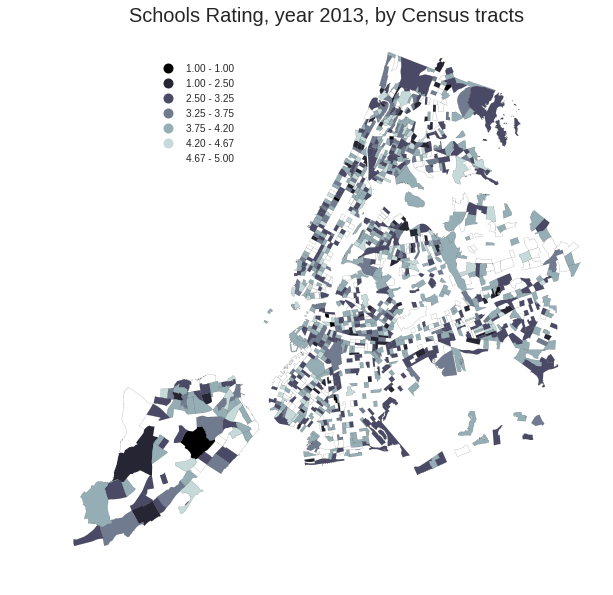

In [50]:
# Rating 13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolsCT, column='Rating13', cmap='bone', scheme='Fisher_Jenks', k=7, edgecolor='k', lw=.1, ax=ax)
plt.title("Schools Rating, year 2013, by Census tracts", fontsize=20);

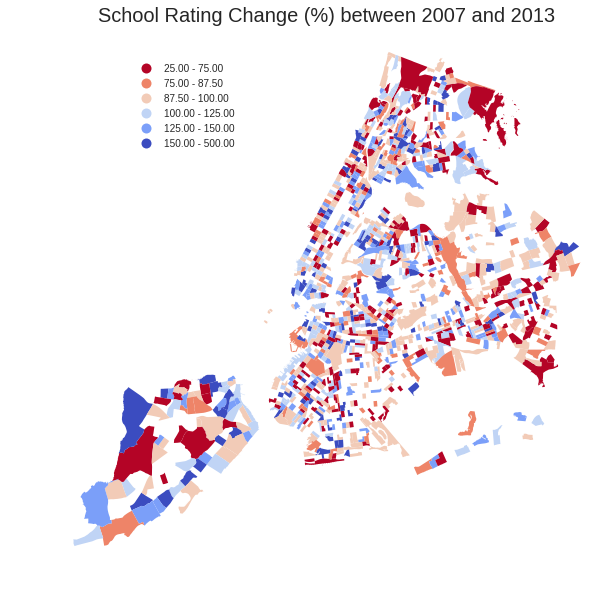

In [51]:
# change 07-13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolsCT, column='RatingChange', cmap='coolwarm_r', scheme='Quantiles', k=7, edgecolor=None, lw=.1, ax=ax);
plt.title("School Rating Change (%) between 2007 and 2013", fontsize=20);

# Reading in Crime Data

In [52]:
crime07 = pd.read_csv('drug07_ct.csv')
#crime07 = crime07.drop('Unnamed: 0',axis=1)
crime07.head()

,FID,FID_1,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,...,Shape_Area,Count_,Sum_Field1,Sum_CMPLNT,Sum_KY_CD,Sum_PD_CD,Sum_X_COOR,Sum_Y_COOR,Sum_Latitu,Sum_Longit
0,0,0,9.0,5,Staten Island,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,...,2.497010e+06,7,1424295,0,1527,3792.0,6732329.0,1212851.0,284.495590,-518.567250
1,1,1,98.0,1,Manhattan,9800,1009800,I,MN19,Turtle Bay-East Midtown,...,1.906016e+06,3,940972,1879906490,587,1523.0,2979367.0,645190.0,122.270938,-221.903929
2,2,2,100.0,1,Manhattan,10000,1010000,I,MN19,Turtle Bay-East Midtown,...,1.860938e+06,1,326781,347216276,235,567.0,992729.0,215329.0,40.757709,-73.969396
3,3,3,102.0,1,Manhattan,10200,1010200,I,MN17,Midtown-Midtown South,...,1.860993e+06,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000
4,4,4,104.0,1,Manhattan,10400,1010400,I,MN17,Midtown-Midtown South,...,1.864600e+06,2,517328,624813215,470,1078.0,1981230.0,432258.0,81.519813,-147.954051


In [53]:
crime07 = crime07[['CT2010','Count_']]
crime07.columns = ['CT2010', 'Count07']
#crime07 = crime07.set_index('CT2010')
crime07.head()

,CT2010,Count07
0,900,7
1,9800,3
2,10000,1
3,10200,0
4,10400,2


In [54]:
crime13 = pd.read_csv('drug13_ct.csv')
#crime13 = crime13.drop('Unnamed: 0',axis=1)
crime13.head()

,FID,FID_1,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,...,Shape_Area,Count_,Sum_Field1,Sum_CMPLNT,Sum_KY_CD,Sum_PD_CD,Sum_X_COOR,Sum_Y_COOR,Sum_Latitu,Sum_Longit
0,0,0,9.0,5,Staten Island,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,...,2.497010e+06,6,1504874,0,1292,3282.0,5767225.0,1039668.0,243.853577,-444.498259
1,1,1,98.0,1,Manhattan,9800,1009800,I,MN19,Turtle Bay-East Midtown,...,1.906016e+06,5,370904,0,1175,2781.0,4966023.0,1072796.0,203.777978,-369.838401
2,2,2,100.0,1,Manhattan,10000,1010000,I,MN19,Turtle Bay-East Midtown,...,1.860938e+06,2,261003,1500232066,470,1022.0,1984098.0,429773.0,81.512990,-147.943702
3,3,3,102.0,1,Manhattan,10200,1010200,I,MN17,Midtown-Midtown South,...,1.860993e+06,1,139150,508905073,235,567.0,991076.0,215501.0,40.758183,-73.975362
4,4,4,104.0,1,Manhattan,10400,1010400,I,MN17,Midtown-Midtown South,...,1.864600e+06,11,1629691,0,2585,6069.0,10894654.0,2380434.0,448.367249,-813.754900


In [55]:
crime13 = crime13[['CT2010','Count_']]
crime13.columns = ['CT2010', 'Count13']
#crime13 = crime13.set_index('CT2010')
crime13.head()

,CT2010,Count13
0,900,6
1,9800,5
2,10000,2
3,10200,1
4,10400,11


In [56]:
crime13.shape

(2166, 2)

In [57]:
crime07.shape

(2166, 2)

In [58]:
crimes = crime13.merge(crime07, left_index=True, right_index=True)
crimes.head()

,CT2010_x,Count13,CT2010_y,Count07
0,900,6,900,7
1,9800,5,9800,3
2,10000,2,10000,1
3,10200,1,10200,0
4,10400,11,10400,2


In [59]:
crimes.shape

(2166, 4)

In [60]:
crimes = crimes[['CT2010_x','Count13','Count07']]
crimes.columns = ['CT2010','Count13','Count07']
crimes.head()

,CT2010,Count13,Count07
0,900,6,7
1,9800,5,3
2,10000,2,1
3,10200,1,0
4,10400,11,2


# Merging with CT shp / Schools data

In [61]:
geoschoolsCT = geoschoolsCT.merge(crimes, on='CT2010')

In [62]:
geoschoolsCT.shape

(3071, 17)

In [63]:
geoschoolsCT.head()

,CT2010,Rating07,Rating13,RatingChange,BoroCT2010,BoroCode,BoroName,CDEligibil,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Count13,Count07
0,100,4.0,4.0,100.0,2000100,2,Bronx,I,1,BX98,Rikers Island,3710,1.815460e+07,18903.346859,"POLYGON ((1019454.697021484 225654.3287963268,...",0,0
1,100,4.0,4.0,100.0,2000100,2,Bronx,I,1,BX98,Rikers Island,3710,1.815460e+07,18903.346859,"POLYGON ((1019454.697021484 225654.3287963268,...",1,13
2,100,4.0,4.0,100.0,2000100,2,Bronx,I,1,BX98,Rikers Island,3710,1.815460e+07,18903.346859,"POLYGON ((1019454.697021484 225654.3287963268,...",2,2
3,100,4.0,4.0,100.0,2000100,2,Bronx,I,1,BX98,Rikers Island,3710,1.815460e+07,18903.346859,"POLYGON ((1019454.697021484 225654.3287963268,...",17,0
4,100,4.0,4.0,100.0,1000100,1,Manhattan,I,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((972081.7880249015 190733.4670409563...,0,0


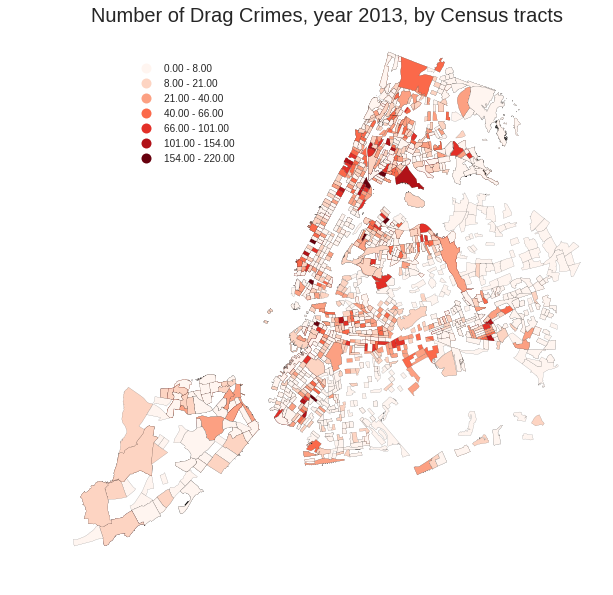

In [64]:
# Crime 13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolsCT, column='Count13', cmap='Reds', scheme='Fisher_Jenks', k=7, edgecolor='k', lw=.1, ax=ax)
plt.title("Number of Drag Crimes, year 2013, by Census tracts", fontsize=20);

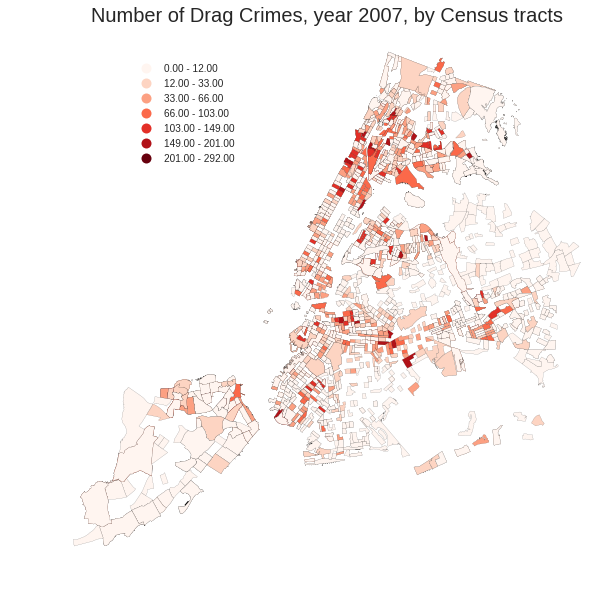

In [65]:
# Crime 07

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolsCT, column='Count07', cmap='Reds', scheme='Fisher_Jenks', k=7, edgecolor='k', lw=.1, ax=ax)
plt.title("Number of Drag Crimes, year 2007, by Census tracts", fontsize=20);